In [ ]:
# Assigment 4 by FinTech group
# Group members:
# Egamberdiyev Temurbek
# Pulatov Jamshid
# Abdurayimov Jalol
# Ruzimurodov Abbos


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting

plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# Set parameters for the data generating process
n_samples = 200        # Number of observations
n_features = 50        # Total number of features
n_informative = 10      # Number of features with non-zero coefficients
noise_level = 1.0       # Standard deviation of the noise

# Generate feature matrix X
# Each column is a feature drawn from standard normal distribution
X = np.random.randn(n_samples, n_features)

# Create the true coefficient vector (beta)
# Most coefficients are zero (sparse model)
true_coefficients = np.zeros(n_features)

# Randomly select which features will have non-zero coefficients
informative_features = np.random.choice(n_features, n_informative, replace=False)
print(f"True informative features indices: {sorted(informative_features)}")

# Assign non-zero values to selected coefficients
# Values are drawn from a normal distribution with larger variance
for idx in informative_features:
    true_coefficients[idx] = np.random.randn() * 3

# Generate the response variable Y
# Y = X * beta + noise
Y = X @ true_coefficients + np.random.randn(n_samples) * noise_level

# Save the data and true coefficients for later analysis
data_dict = {
    'X': X,
    'Y': Y,
    'true_coefficients': true_coefficients,
    'informative_features': informative_features
}

# Create a DataFrame to better visualize the coefficients
coef_df = pd.DataFrame({
    'feature_index': range(n_features),
    'true_coefficient': true_coefficients
})

# Show the non-zero coefficients
print("\nNon-zero coefficients:")
print(coef_df[coef_df['true_coefficient'] != 0])

True informative features indices: [np.int32(0), np.int32(2), np.int32(4), np.int32(10), np.int32(15), np.int32(17), np.int32(19), np.int32(23), np.int32(44), np.int32(45)]

Non-zero coefficients:
    feature_index  true_coefficient
0               0         -5.038946
2               2         -2.678609
4               4         -1.823795
10             10         -1.610677
15             15         -2.561768
17             17          0.393326
19             19          1.786967
23             23          5.059156
44             44         -0.493334
45             45          5.933621


In [5]:
# Split the data into training and testing sets
# We use 70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Standardize the features (important for regularized regression)
# Fit the scaler on training data and apply to both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set size: (140, 50)
Test set size: (60, 50)


In [6]:
# Define different alpha values to test
# Alpha controls the strength of regularization
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

# Store results for each alpha
lasso_results = {}

for alpha in alphas:
    # Create and fit Lasso model
    # max_iter: maximum number of iterations for optimization
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, Y_train)
    
    # Make predictions
    Y_train_pred = lasso.predict(X_train_scaled)
    Y_test_pred = lasso.predict(X_test_scaled)
    
    # Calculate metrics
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)
    
    # Count non-zero coefficients
    n_nonzero = np.sum(lasso.coef_ != 0)
    
    # Store results
    lasso_results[alpha] = {
        'model': lasso,
        'coefficients': lasso.coef_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_nonzero_coef': n_nonzero
    }
    
    print(f"\nAlpha = {alpha}")
    print(f"  Non-zero coefficients: {n_nonzero}")
    print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


Alpha = 0.0001
  Non-zero coefficients: 50
  Train MSE: 0.6324, Test MSE: 1.4795
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.001
  Non-zero coefficients: 50
  Train MSE: 0.6324, Test MSE: 1.4605
  Train R²: 0.9952, Test R²: 0.9874

Alpha = 0.01
  Non-zero coefficients: 49
  Train MSE: 0.6408, Test MSE: 1.3003
  Train R²: 0.9951, Test R²: 0.9888

Alpha = 0.1
  Non-zero coefficients: 19
  Train MSE: 0.9011, Test MSE: 1.0314
  Train R²: 0.9931, Test R²: 0.9911

Alpha = 0.5
  Non-zero coefficients: 8
  Train MSE: 3.3757, Test MSE: 3.0970
  Train R²: 0.9743, Test R²: 0.9733

Alpha = 1.0
  Non-zero coefficients: 8
  Train MSE: 8.9801, Test MSE: 9.0886
  Train R²: 0.9316, Test R²: 0.9216


In [7]:
# Store Ridge results for comparison
ridge_results = {}

for alpha in alphas:
    # Create and fit Ridge model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, Y_train)
    
    # Make predictions
    Y_train_pred = ridge.predict(X_train_scaled)
    Y_test_pred = ridge.predict(X_test_scaled)
    
    # Calculate metrics
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    test_mse = mean_squared_error(Y_test, Y_test_pred)
    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)
    
    # For Ridge, count "effectively zero" coefficients (very small)
    threshold = 0.001
    n_small = np.sum(np.abs(ridge.coef_) < threshold)
    
    # Store results
    ridge_results[alpha] = {
        'model': ridge,
        'coefficients': ridge.coef_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_small_coef': n_small
    }
    
    print(f"\nAlpha = {alpha}")
    print(f"  Coefficients < {threshold}: {n_small}")
    print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


Alpha = 0.0001
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4816
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.001
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4816
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.01
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4812
  Train R²: 0.9952, Test R²: 0.9872

Alpha = 0.1
  Coefficients < 0.001: 0
  Train MSE: 0.6324, Test MSE: 1.4778
  Train R²: 0.9952, Test R²: 0.9873

Alpha = 0.5
  Coefficients < 0.001: 0
  Train MSE: 0.6343, Test MSE: 1.4666
  Train R²: 0.9952, Test R²: 0.9873

Alpha = 1.0
  Coefficients < 0.001: 1
  Train MSE: 0.6402, Test MSE: 1.4614
  Train R²: 0.9951, Test R²: 0.9874


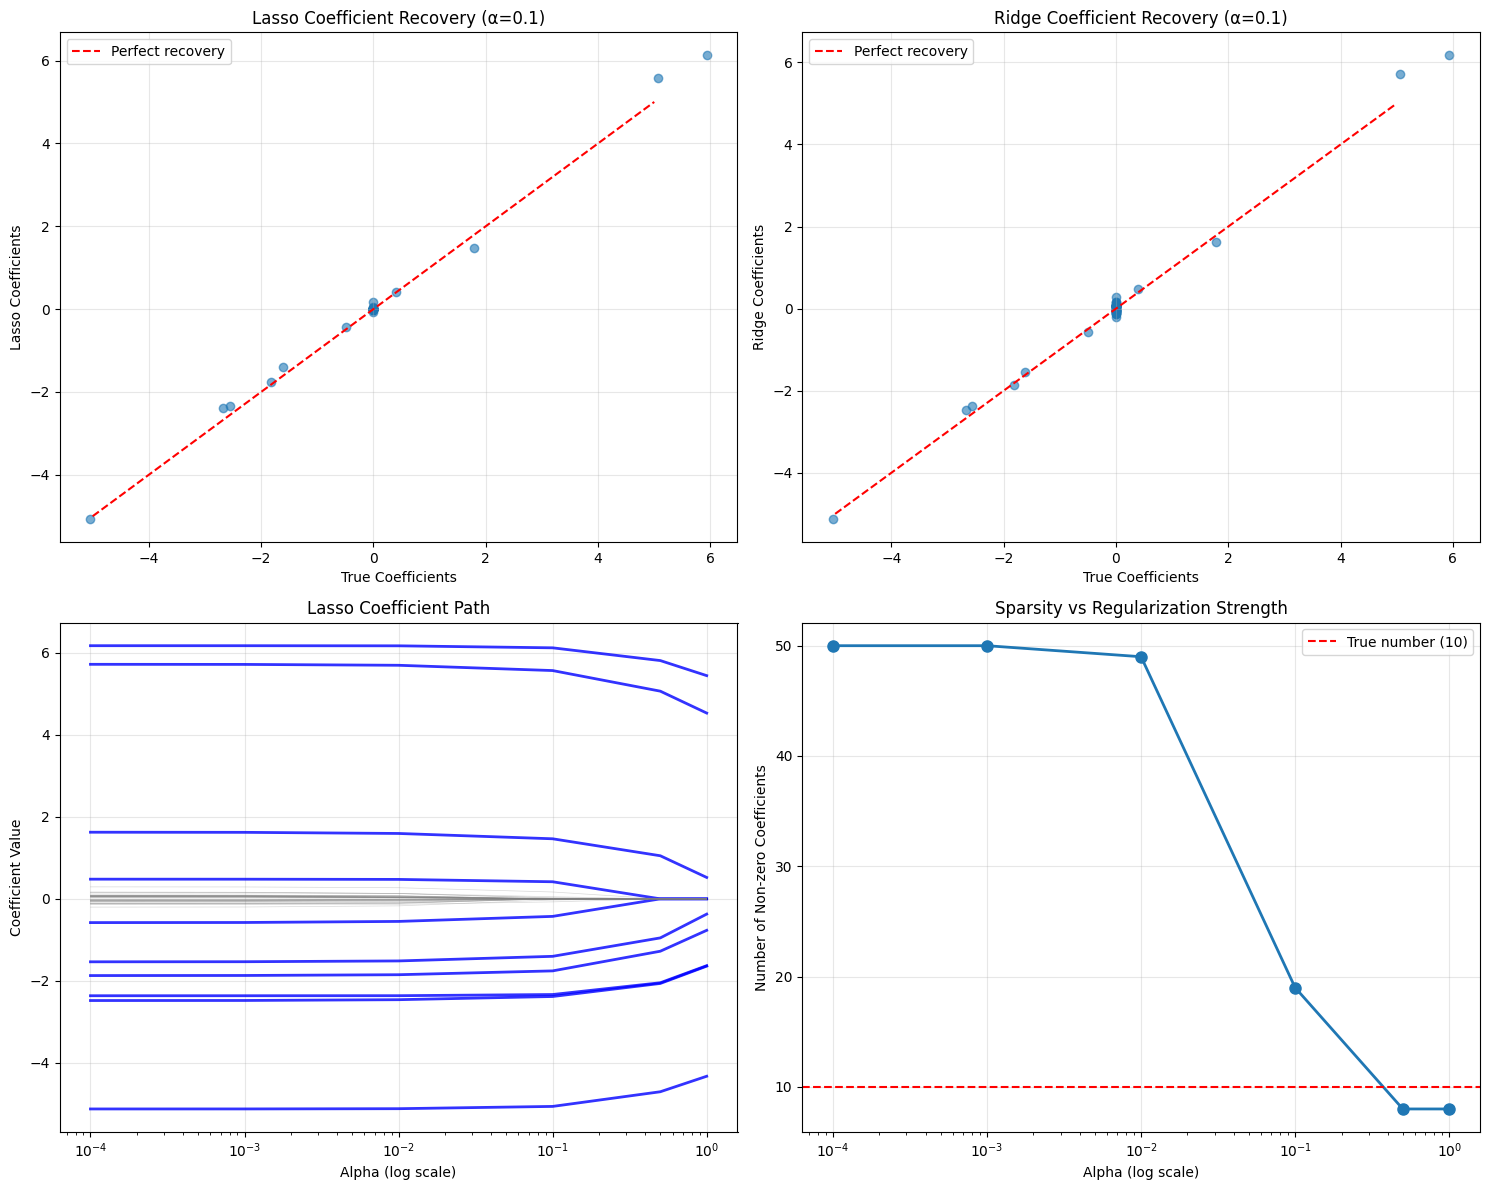

In [8]:
# Select a specific alpha for detailed comparison
selected_alpha = 0.1

# Get the coefficients for the selected alpha
lasso_coef = lasso_results[selected_alpha]['coefficients']
ridge_coef = ridge_results[selected_alpha]['coefficients']

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Lasso coefficients vs True coefficients
ax1 = axes[0, 0]
ax1.scatter(true_coefficients, lasso_coef, alpha=0.6)
ax1.plot([-5, 5], [-5, 5], 'r--', label='Perfect recovery')
ax1.set_xlabel('True Coefficients')
ax1.set_ylabel('Lasso Coefficients')
ax1.set_title(f'Lasso Coefficient Recovery (α={selected_alpha})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Ridge coefficients vs True coefficients
ax2 = axes[0, 1]
ax2.scatter(true_coefficients, ridge_coef, alpha=0.6)
ax2.plot([-5, 5], [-5, 5], 'r--', label='Perfect recovery')
ax2.set_xlabel('True Coefficients')
ax2.set_ylabel('Ridge Coefficients')
ax2.set_title(f'Ridge Coefficient Recovery (α={selected_alpha})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Coefficient path for Lasso
ax3 = axes[1, 0]
for idx in informative_features:
    coef_path = [lasso_results[alpha]['coefficients'][idx] for alpha in alphas]
    ax3.plot(alphas, coef_path, 'b-', linewidth=2, alpha=0.8)
# Plot non-informative features in lighter color
for idx in range(n_features):
    if idx not in informative_features:
        coef_path = [lasso_results[alpha]['coefficients'][idx] for alpha in alphas]
        ax3.plot(alphas, coef_path, 'gray', linewidth=0.5, alpha=0.3)
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (log scale)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Lasso Coefficient Path')
ax3.grid(True, alpha=0.3)

# Plot 4: Number of non-zero coefficients vs alpha
ax4 = axes[1, 1]
nonzero_counts = [lasso_results[alpha]['n_nonzero_coef'] for alpha in alphas]
ax4.plot(alphas, nonzero_counts, 'o-', linewidth=2, markersize=8)
ax4.axhline(y=n_informative, color='r', linestyle='--', 
            label=f'True number ({n_informative})')
ax4.set_xscale('log')
ax4.set_xlabel('Alpha (log scale)')
ax4.set_ylabel('Number of Non-zero Coefficients')
ax4.set_title('Sparsity vs Regularization Strength')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Optimal alpha from cross-validation: 0.0735
Test MSE with optimal alpha: 1.0446
Test R² with optimal alpha: 0.9910


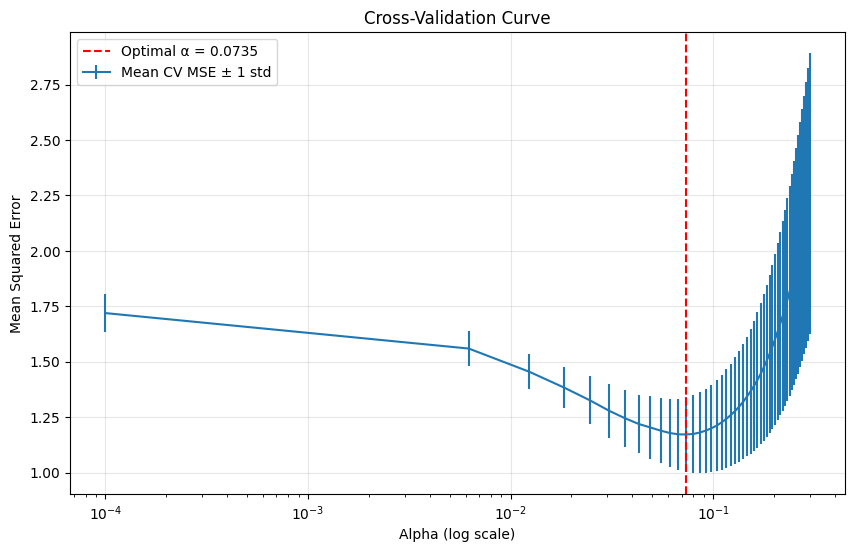

In [9]:
# Use LassoCV for automatic alpha selection
from sklearn.linear_model import LassoCV

# Define a range of alphas to test
alphas_cv = np.linspace(0.0001, 0.3, 50)

# Perform cross-validation
# cv=5 means 5-fold cross-validation
lasso_cv = LassoCV(alphas=alphas_cv, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, Y_train)

# Get the optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha from cross-validation: {optimal_alpha:.4f}")

# Evaluate the model with optimal alpha
Y_test_pred_cv = lasso_cv.predict(X_test_scaled)
test_mse_cv = mean_squared_error(Y_test, Y_test_pred_cv)
test_r2_cv = r2_score(Y_test, Y_test_pred_cv)

print(f"Test MSE with optimal alpha: {test_mse_cv:.4f}")
print(f"Test R² with optimal alpha: {test_r2_cv:.4f}")


# Plot the cross-validation curve
plt.figure(figsize=(10, 6))
plt.errorbar(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), 
            yerr=lasso_cv.mse_path_.std(axis=1), 
            label='Mean CV MSE ± 1 std')
plt.axvline(x=optimal_alpha, color='r', linestyle='--', 
           label=f'Optimal α = {optimal_alpha:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Create a summary comparison
summary_data = []

# Add Lasso results
for alpha in alphas:
    summary_data.append({
        'Method': 'Lasso',
        'Alpha': alpha,
        'Test MSE': lasso_results[alpha]['test_mse'],
        'Test R²': lasso_results[alpha]['test_r2'],
        'Non-zero Coefficients': lasso_results[alpha]['n_nonzero_coef']
    })

# Add Ridge results
for alpha in alphas:
    summary_data.append({
        'Method': 'Ridge',
        'Alpha': alpha,
        'Test MSE': ridge_results[alpha]['test_mse'],
        'Test R²': ridge_results[alpha]['test_r2'],
        'Non-zero Coefficients': n_features  # Ridge doesn't set coefficients to zero
    })

# Add CV Lasso result
summary_data.append({
    'Method': 'Lasso (CV)',
    'Alpha': optimal_alpha,
    'Test MSE': test_mse_cv,
    'Test R²': test_r2_cv,
    'Non-zero Coefficients': np.sum(lasso_cv.coef_ != 0)
})

summary_df = pd.DataFrame(summary_data)
print("\nModel Comparison Summary:")
print(summary_df)


Model Comparison Summary:
        Method     Alpha  Test MSE   Test R²  Non-zero Coefficients
0        Lasso  0.000100  1.479455  0.987239                     50
1        Lasso  0.001000  1.460491  0.987402                     50
2        Lasso  0.010000  1.300284  0.988784                     49
3        Lasso  0.100000  1.031406  0.991103                     19
4        Lasso  0.500000  3.097040  0.973286                      8
5        Lasso  1.000000  9.088628  0.921605                      8
6        Ridge  0.000100  1.481606  0.987220                     50
7        Ridge  0.001000  1.481570  0.987220                     50
8        Ridge  0.010000  1.481209  0.987224                     50
9        Ridge  0.100000  1.477788  0.987253                     50
10       Ridge  0.500000  1.466591  0.987350                     50
11       Ridge  1.000000  1.461376  0.987395                     50
12  Lasso (CV)  0.073545  1.044583  0.990990                     23


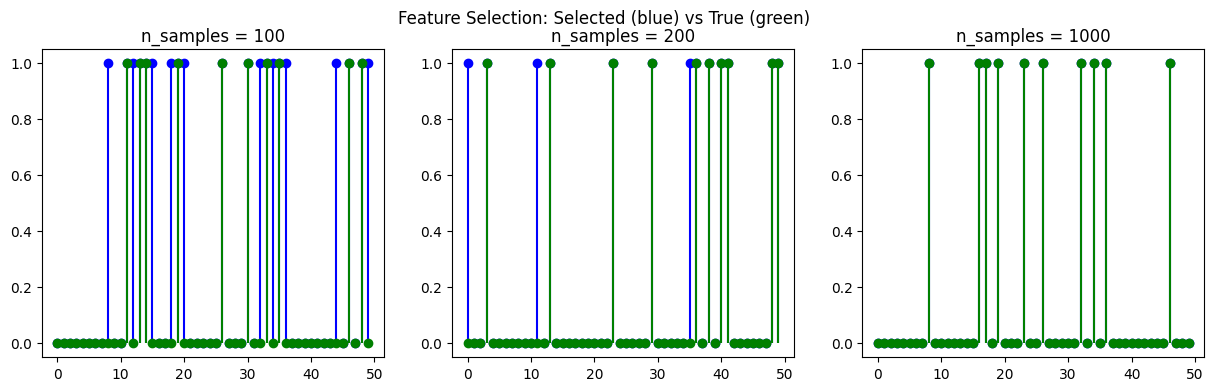

In [11]:
# 10.1 Exercise 1: Effect of Sample Size
sample_sizes = [100, 200, 1000]
n_features = 50
n_informative = 10
alpha = 0.1

results = {}

for n in sample_sizes:
    X = np.random.randn(n, n_features)
    true_coeff = np.zeros(n_features)
    informative_idx = np.random.choice(n_features, n_informative, replace=False)
    true_coeff[informative_idx] = np.random.randn(n_informative) * 3
    Y = X @ true_coeff + np.random.randn(n) * 1.0

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, Y)
    selected = (lasso.coef_ != 0)
    results[n] = (selected, informative_idx)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, n in enumerate(sample_sizes):
    selected, true_idx = results[n]
    axes[i].stem(selected, linefmt='b-', markerfmt='bo', basefmt=' ')
    axes[i].stem([i in true_idx for i in range(n_features)], linefmt='g-', markerfmt='go', basefmt=' ')
    axes[i].set_title(f"n_samples = {n}")
plt.suptitle("Feature Selection: Selected (blue) vs True (green)")
plt.show()


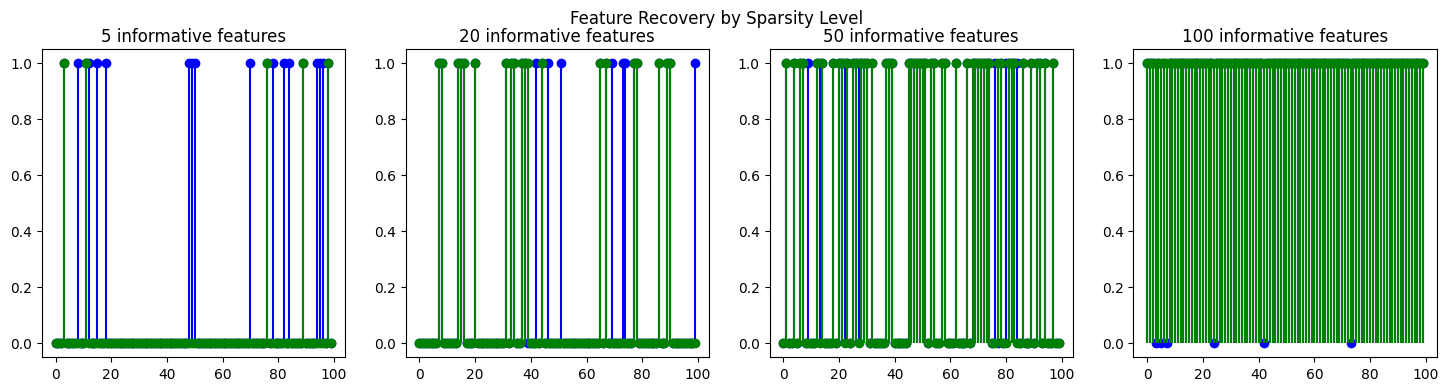

In [12]:
# 10.2 Exercise 2: Different Sparsity Levels
informative_counts = [5, 20, 50, 100]
n_samples = 200
n_features = 100
alpha = 0.1

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, k in enumerate(informative_counts):
    X = np.random.randn(n_samples, n_features)
    true_coeff = np.zeros(n_features)
    idx = np.random.choice(n_features, k, replace=False)
    true_coeff[idx] = np.random.randn(k) * 3
    Y = X @ true_coeff + np.random.randn(n_samples)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X, Y)
    selected = (lasso.coef_ != 0)

    axes[i].stem(selected, linefmt='b-', markerfmt='bo', basefmt=' ')
    axes[i].stem([j in idx for j in range(n_features)], linefmt='g-', markerfmt='go', basefmt=' ')
    axes[i].set_title(f"{k} informative features")
plt.suptitle("Feature Recovery by Sparsity Level")
plt.show()


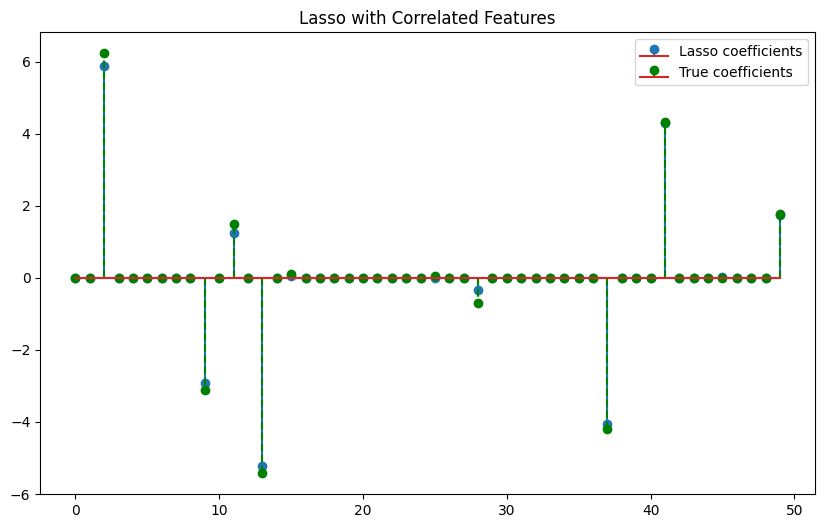

In [13]:
# 10.3 Exercise 3: Correlated Features
from numpy.random import multivariate_normal

n_samples = 200
n_features = 50
n_informative = 10
alpha = 0.1

# Корреляционная матрица
corr = 0.5
cov_matrix = corr * np.ones((n_features, n_features)) + (1 - corr) * np.eye(n_features)

X = multivariate_normal(np.zeros(n_features), cov_matrix, size=n_samples)
true_coeff = np.zeros(n_features)
idx = np.random.choice(n_features, n_informative, replace=False)
true_coeff[idx] = np.random.randn(n_informative) * 3
Y = X @ true_coeff + np.random.randn(n_samples)

lasso = Lasso(alpha=alpha)
lasso.fit(X, Y)

plt.stem(lasso.coef_, label='Lasso coefficients')
plt.stem(true_coeff, linefmt='g--', markerfmt='go', label='True coefficients')
plt.title("Lasso with Correlated Features")
plt.legend()
plt.show()


In [ ]:
# 10.4 Exercise 3: Interpretation
# 1) 1. Why does Lasso perform feature selection while Ridge doesn’t?
# Lasso uses L1 regularization, which minimizes the sum of the coefficient absolute values. Geometrically, 
# this creates conditions under which the model's solution "hits" the axes, zeroing out some coefficients — thereby implementing feature selection. 
# In contrast, Ridge uses L2 regularization, penalizing the squares of the coefficients, which only reduces their values, 
# but does not make them strictly zero. Therefore, Ridge "squeezes" and Lasso "zeros". 

# 2) In what situations would you prefer Lasso over Ridge?
# Lasso is best used when it is assumed that only a small number of features actually influence the target variable — that is, 
# the model is sparse. It is also useful for high-dimensional data (many features, few observations), 
# as it helps to automatically exclude irrelevant variables. Lasso is especially relevant if interpretability of the model is important.

# 3) What are the limitations of Lasso for feature selection?
# The main limitation of Lasso is its instability in the presence of highly correlated features: it tends to randomly select one 
# of the group and ignore the others, even if they are also important. Also, when the number of features exceeds the number of observations, 
# Lasso can be sensitive to data changes, producing inconsistent selection results. Another disadvantage is that it does not work well when 
# all features are important, since by its nature it tends to be sparse.